In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import geopandas as gpd
import shapely
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
europe_grid = gpd.read_file('../../data/Countries_WGS84/processed/Europe_Evaluation_Grid.shp')
europe_borders = gpd.read_file('../../data/Countries_WGS84/processed/Europe_WGS84.shp')
# coast_grid = gpd.read_file('../../data/Countries_WGS84/processed/Coast_Evaluation_Grid.shp')
# coast_grid.to_crs(europe_grid.crs,inplace=True)

# Post-processs full load hours

In [50]:
results = pd.DataFrame()
for country in europe_grid.country.unique():
    df = pd.read_csv(f'../../results/01_merra_wind_preprocessing/post-processed/{country}.csv')
    df['country'] = country
    results = results.append(df)
results.reset_index(drop=True,inplace=True)

In [52]:
results_gdf = gpd.GeoDataFrame(europe_grid.merge(results,left_on=['merra_lat','merra_lon','country'],right_on=['lat','lon','country'],how='left'))
results_gdf

,grid_lat,grid_lon,in_country,pt_in_sea,country,coast_pt,sea_node,cent_lat,cent_lon,merra_lat,...,v_50m,v_hub,rated_power_MW,hours,rotor_diameter,turbine_type,specific_capacity_class,rep_hub_height,hub_height,FLh
0,47.0,9.375,0,0,Austria,0,0,47.164853,9.645249,47.0,...,2.254462,3.499552,3.30,8784,131.0,N131/3300,lo,164.0,164.0,904.280487
1,47.5,9.375,0,0,Austria,0,0,47.377633,9.631662,47.5,...,3.635911,4.861311,3.30,8784,131.0,N131/3300,lo,164.0,164.0,1859.840968
2,47.0,10.000,1,0,Austria,0,0,47.082648,10.034669,47.0,...,2.532394,3.936291,3.30,8784,131.0,N131/3300,lo,164.0,164.0,1168.108574
3,47.5,10.000,1,0,Austria,0,0,47.387844,9.928262,47.5,...,3.624481,5.047656,3.30,8784,131.0,N131/3300,lo,164.0,164.0,1964.366405
4,47.0,10.625,1,0,Austria,0,0,47.052871,10.656985,47.0,...,2.267755,3.415651,3.30,8784,131.0,N131/3300,lo,164.0,164.0,775.790422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5385,53.5,2.500,0,1,United_Kingdom,0,1,53.394749,2.435181,53.5,...,8.483504,9.289477,6.33,8784,152.0,S152/6330,mid,121.0,121.0,4983.081200
5386,52.0,3.125,0,1,United_Kingdom,0,1,52.041197,2.947868,52.0,...,8.190834,8.881732,6.33,8784,152.0,S152/6330,mid,121.0,121.0,4614.331367
5387,52.5,3.125,0,1,United_Kingdom,0,1,52.502577,3.013187,52.5,...,8.277113,8.994905,6.33,8784,152.0,S152/6330,mid,121.0,121.0,4706.156158
5388,53.0,3.125,0,1,United_Kingdom,0,1,52.956933,2.965299,53.0,...,8.392260,9.141518,6.33,8784,152.0,S152/6330,mid,121.0,121.0,4808.628589


In [53]:
def plot_results(data,countries,metrics,figsize=(25,20),ncols=None,fontsize=None,cmap=None,vmax=None,missing_kwds=None,legend_kwds={}):
    if ncols == None:
        ncols = int(np.ceil(np.sqrt(len(metrics))))
    nrows = int(np.ceil(len(metrics)/ncols))
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    axes = np.reshape(axes,(1,nrows*ncols))[0]

    if fontsize == None:
        fontsize = figsize[0]*2
    df = data.loc[data.country.isin(countries)].copy()
    borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
    for i,(metric,description) in enumerate(metrics.items()):
        if metric not in ['turbine_type','specific_capacity_class']:
            l_kwds = legend_kwds.copy()
            l_kwds.setdefault('orientation','horizontal')
            l_kwds['ax'] = axes[i]
            l_kwds.pop('bbox_to_anchor',None)
            l_kwds.pop('fontsize',None)
        else:
            l_kwds = legend_kwds.copy()
            l_kwds.pop('orientation',None)
            l_kwds.setdefault('loc','upper center')
            l_kwds.setdefault('ncol',min(3,df[metric].nunique()))
            l_kwds.setdefault('fontsize',fontsize*.75)
            
            if df[metric].nunique()>10:
                cmap = 'tab20'
        df.plot(column=metric,legend=True,cmap=cmap,vmax=vmax,missing_kwds=missing_kwds,legend_kwds=l_kwds,ax=axes[i])
        borders.boundary.plot(color='k',ax=axes[i])
        cb_ax = axes[i].figure.axes[-1]
        cb_ax.tick_params(labelsize=fontsize)
        axes[i].axis('off')
        axes[i].set_title(description,fontsize=fontsize)
#     plt.tight_layout()

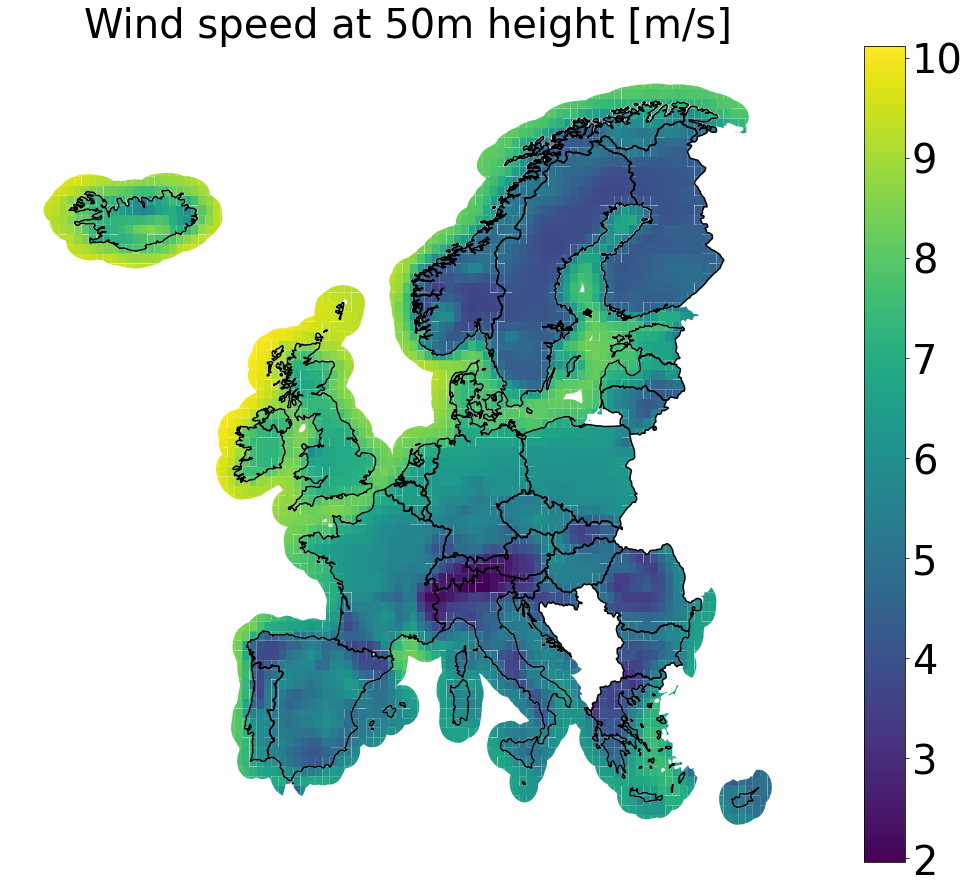

In [55]:
# Wind speed at 50m
data = results_gdf
countries = europe_grid.country.unique()
metrics = {'v_50m':'Wind speed at 50m height [m/s]'}
figsize=(20,15)
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Europe_v_50m'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

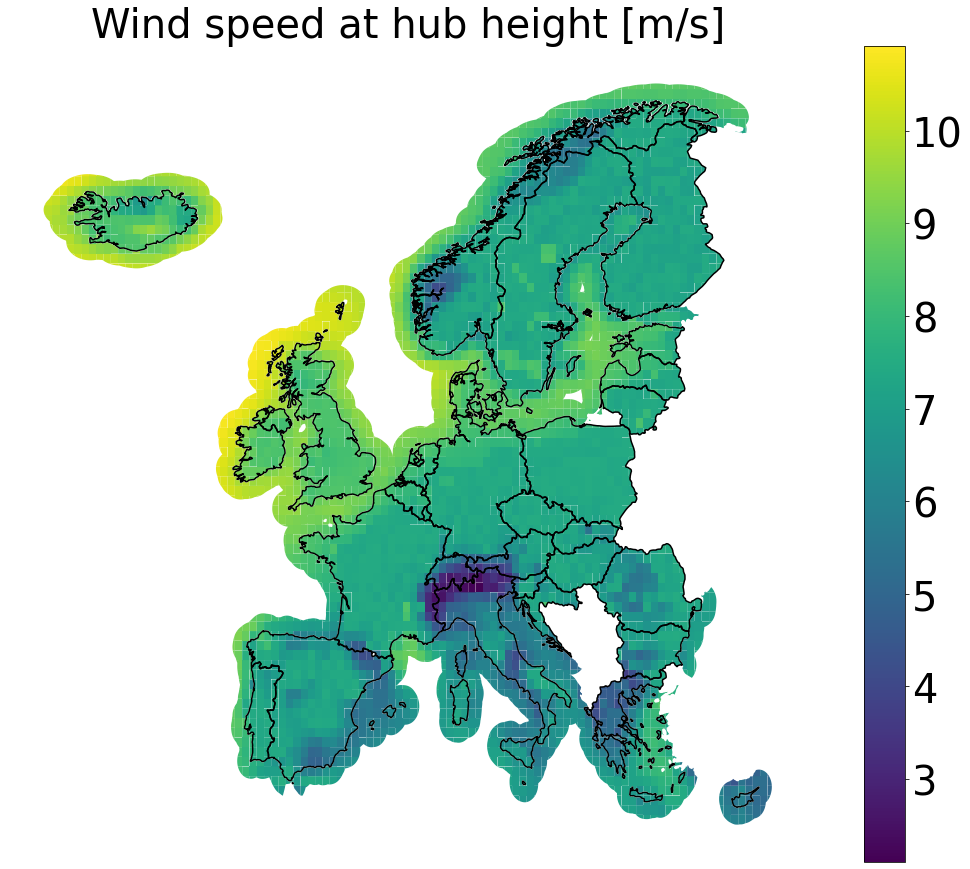

In [57]:
# Wind speed at hub height
data = results_gdf
countries = europe_grid.country.unique()
metrics = {'v_hub':'Wind speed at hub height [m/s]'}
figsize=(20,15)
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Europe_v_hub'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

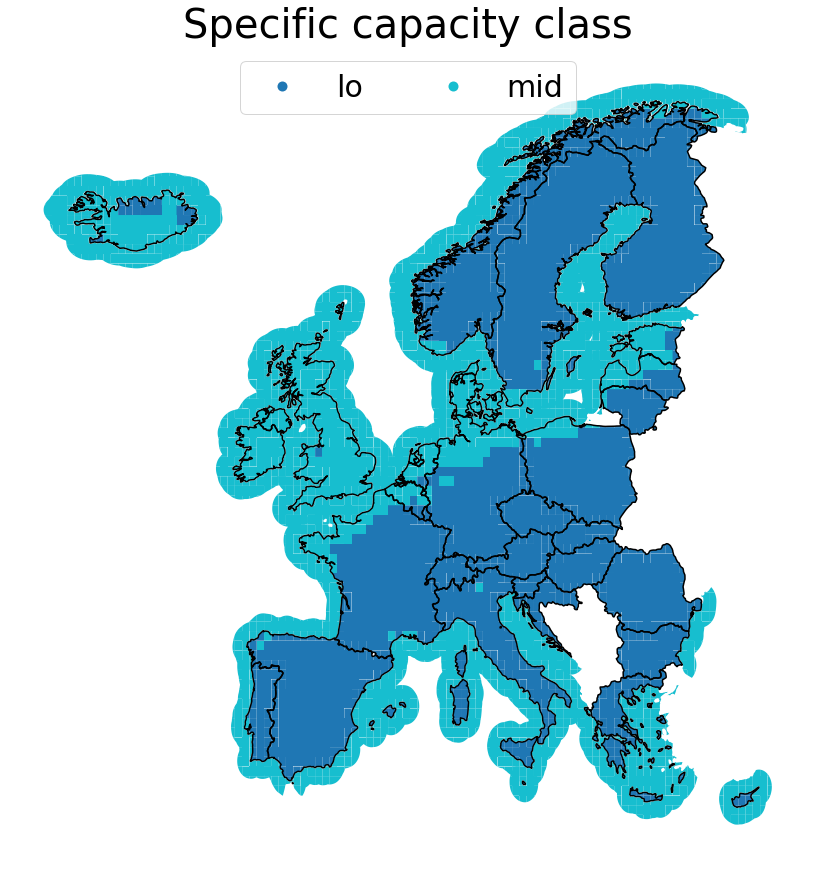

In [59]:
# Wind specific capacity class
data = results_gdf
countries = europe_grid.country.unique()
metrics = {'specific_capacity_class':'Specific capacity class'}
figsize=(20,15)
plot_results(data,countries,metrics,figsize=figsize)
save_file_name = 'Europe_specific_capacity_class'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

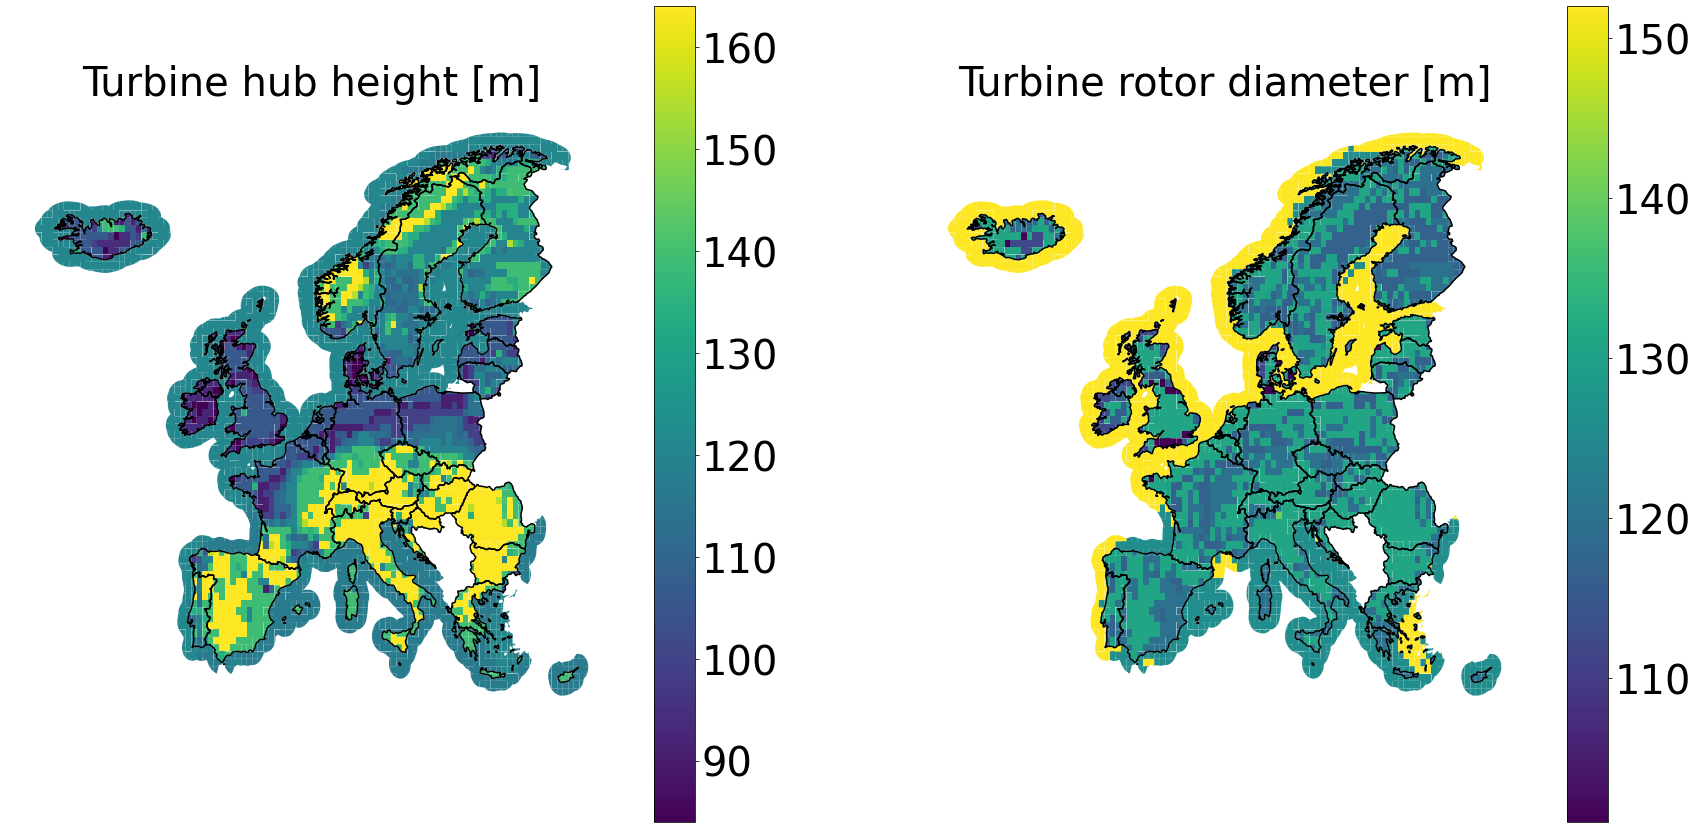

In [61]:
# Turbine hub height & rotor diameter
data = results_gdf
countries = europe_grid.country.unique()
metrics = {'hub_height':'Turbine hub height [m]','rotor_diameter':'Turbine rotor diameter [m]'}
figsize=(30,15)
fontsize=40
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds,fontsize=fontsize)
save_file_name = 'Europe_hub_and_rotor'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

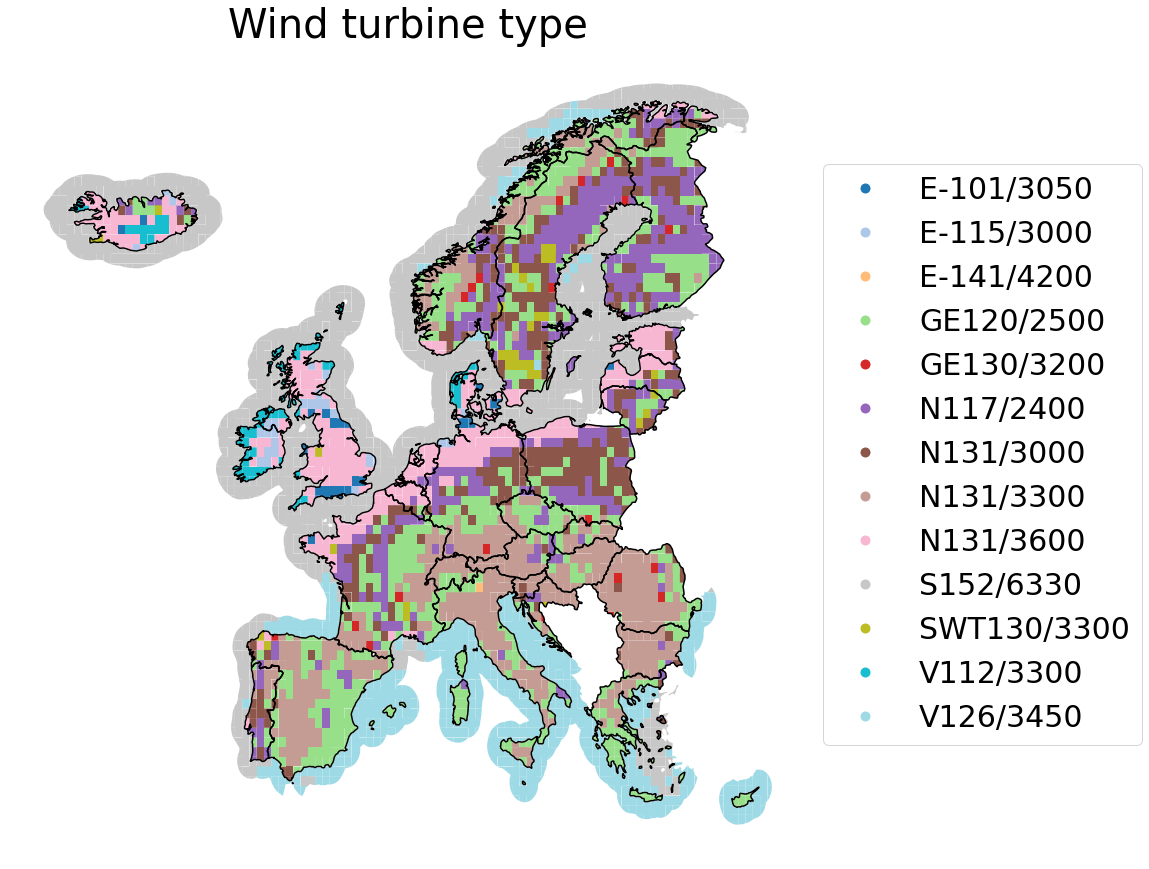

In [63]:
# Wind turbine type
data = results_gdf
countries = europe_grid.country.unique()
metrics = {'turbine_type':'Wind turbine type'}
figsize=(20,15)
legend_kwds = {'bbox_to_anchor':(1,0.5),'loc':'center left','ncol':1}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Europe_turbine_type'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

In [64]:
pd.DataFrame(results_gdf.turbine_type.value_counts()).sort_index()

,turbine_type
E-101/3050,34
E-115/3000,43
E-141/4200,1
GE120/2500,854
GE130/3200,24
N117/2400,474
N131/3000,395
N131/3300,707
N131/3600,427
S152/6330,1536


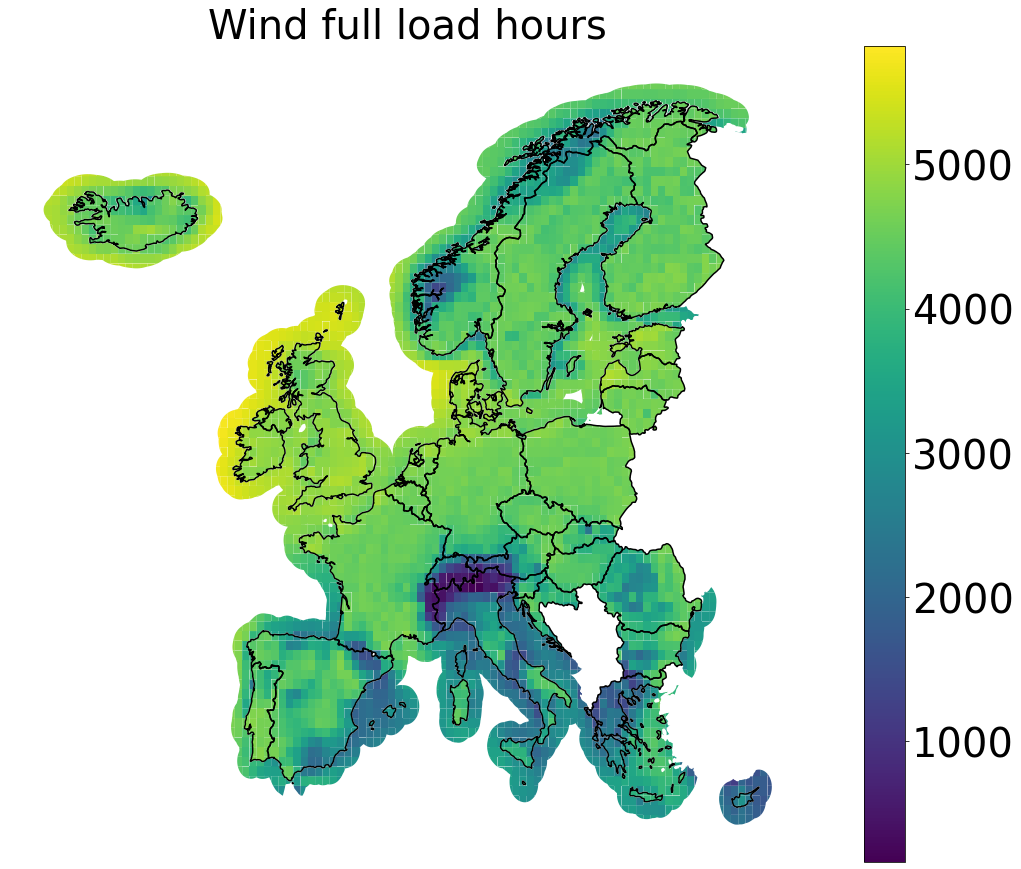

In [67]:
# Full load hours
data = results_gdf
countries = europe_grid.country.unique()
metrics = {'FLh':'Wind full load hours'}
figsize=(20,15)
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Europe_FLh'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

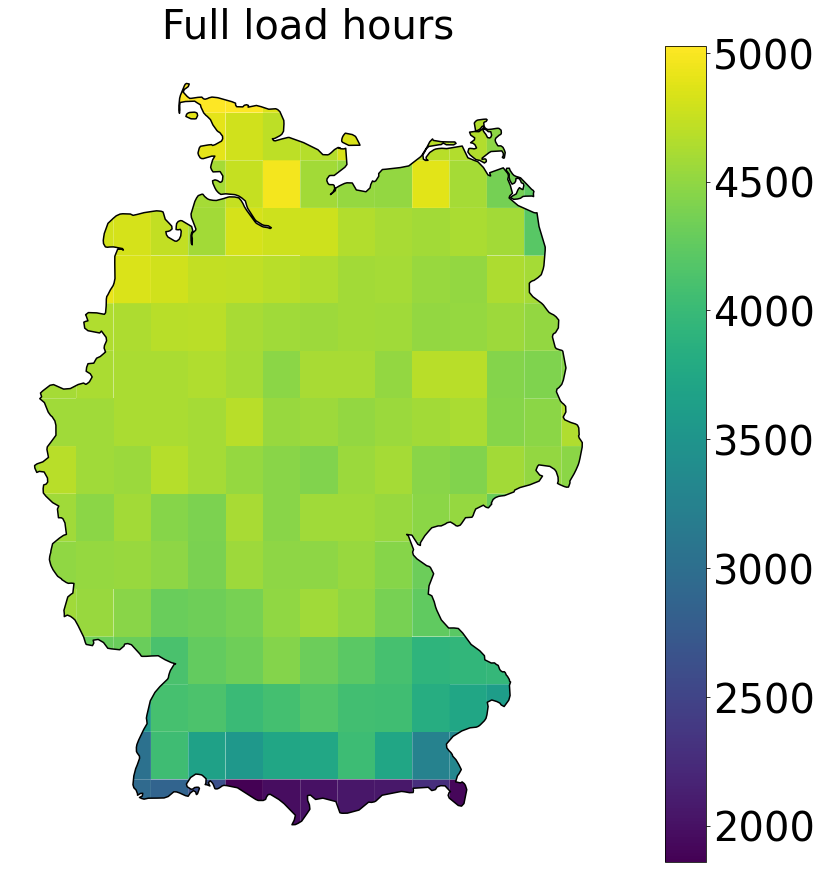

In [12]:
# Full load hours
data = results_gdf
countries = ['Germany']
metrics = {'FLh':'Full load hours'}
figsize=(20,15)
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Germany_FLh'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

In [46]:
data.loc[data.country=='Germany']

,lat,lon,kWh,kWh_max,v_50m,v_hub,rated_power_MW,hours,rotor_diameter,turbine_type,specific_capacity_class,rep_hub_height,hub_height,FLh,country,PV_lat,PV_lon,geometry
900,47.5,7.500,9.707374e+06,3300.0,4.383930,6.071743,3.30,8784,131.0,N131/3300,lo,164.0,164.0,2941.628545,Germany,47.661482,7.682495,"POLYGON ((7.52069 47.75000, 7.81250 47.75000, ..."
901,47.5,8.125,9.468323e+06,3300.0,4.294105,5.920973,3.30,8784,131.0,N131/3300,lo,164.0,164.0,2869.188928,Germany,47.662525,8.103238,"POLYGON ((7.81250 47.75000, 8.43750 47.75000, ..."
902,47.5,8.750,8.701724e+06,3300.0,4.106091,5.641420,3.30,8784,131.0,N131/3300,lo,164.0,164.0,2636.886134,Germany,47.712403,8.913587,"MULTIPOLYGON (((8.73585 47.75000, 9.06250 47.7..."
903,47.5,9.375,6.137475e+06,3300.0,3.635911,4.861311,3.30,8784,131.0,N131/3300,lo,164.0,164.0,1859.840968,Germany,47.669153,9.447813,"POLYGON ((9.06250 47.75000, 9.68750 47.75000, ..."
904,47.5,10.000,6.482409e+06,3300.0,3.624481,5.047656,3.30,8784,131.0,N131/3300,lo,164.0,164.0,1964.366405,Germany,47.595325,10.060972,"POLYGON ((9.68750 47.75000, 10.31250 47.75000,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,55.0,8.750,3.176896e+07,6300.0,7.693188,9.032245,6.33,8784,152.0,S152/6330,mid,121.0,121.0,5018.792726,Germany,54.835008,8.816928,"MULTIPOLYGON (((9.06250 54.88394, 9.06250 54.7..."
1090,55.0,9.375,3.180631e+07,6300.0,7.364152,8.951242,6.33,8784,152.0,S152/6330,mid,121.0,121.0,5024.694028,Germany,54.794091,9.335943,"POLYGON ((9.68750 54.80659, 9.68750 54.75000, ..."
1091,55.0,10.000,3.073885e+07,6300.0,7.474978,8.819443,6.33,8784,152.0,S152/6330,mid,121.0,121.0,4856.059088,Germany,54.770353,9.815098,"POLYGON ((9.97961 54.75000, 9.68750 54.75000, ..."
1092,55.0,13.125,2.913172e+07,6300.0,7.917904,8.719325,6.33,8784,152.0,S152/6330,mid,121.0,121.0,4602.167097,Germany,NaN,NaN,None


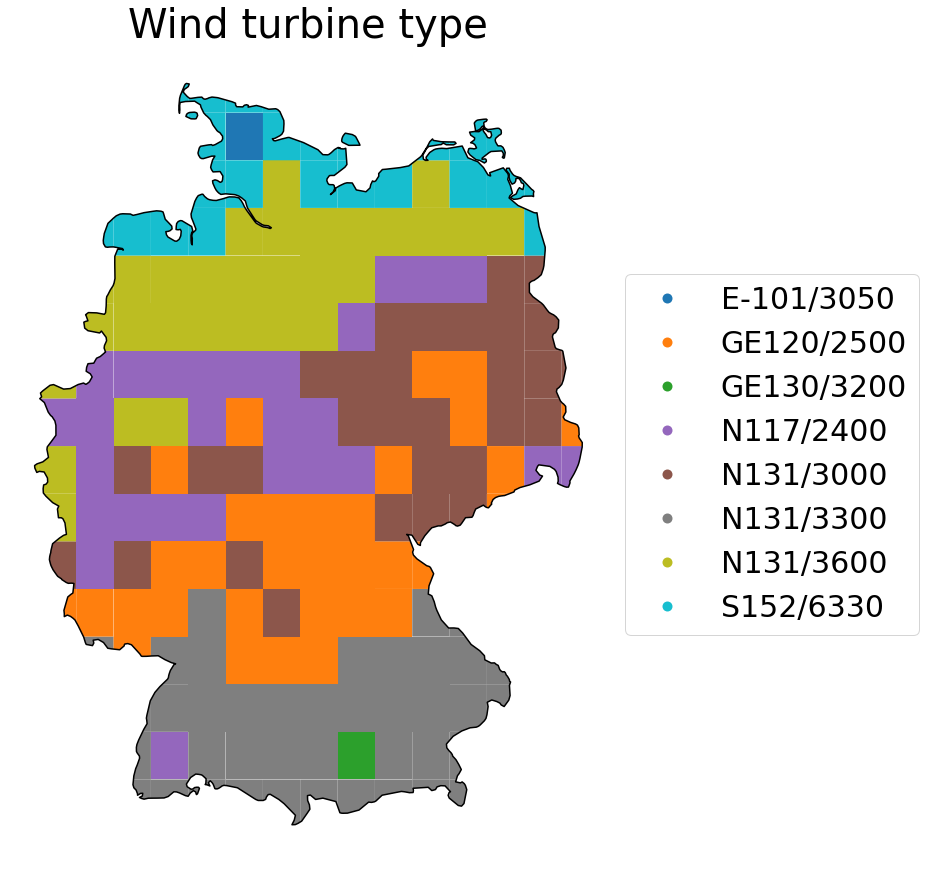

In [14]:
# Full load hours
data = results_gdf.copy()
countries = ['Germany']
metrics = {'turbine_type':'Wind turbine type'}
figsize=(20,15)
legend_kwds = {'bbox_to_anchor':(1,0.5),'loc':'center left','ncol':1}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Germany_turbine_type'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

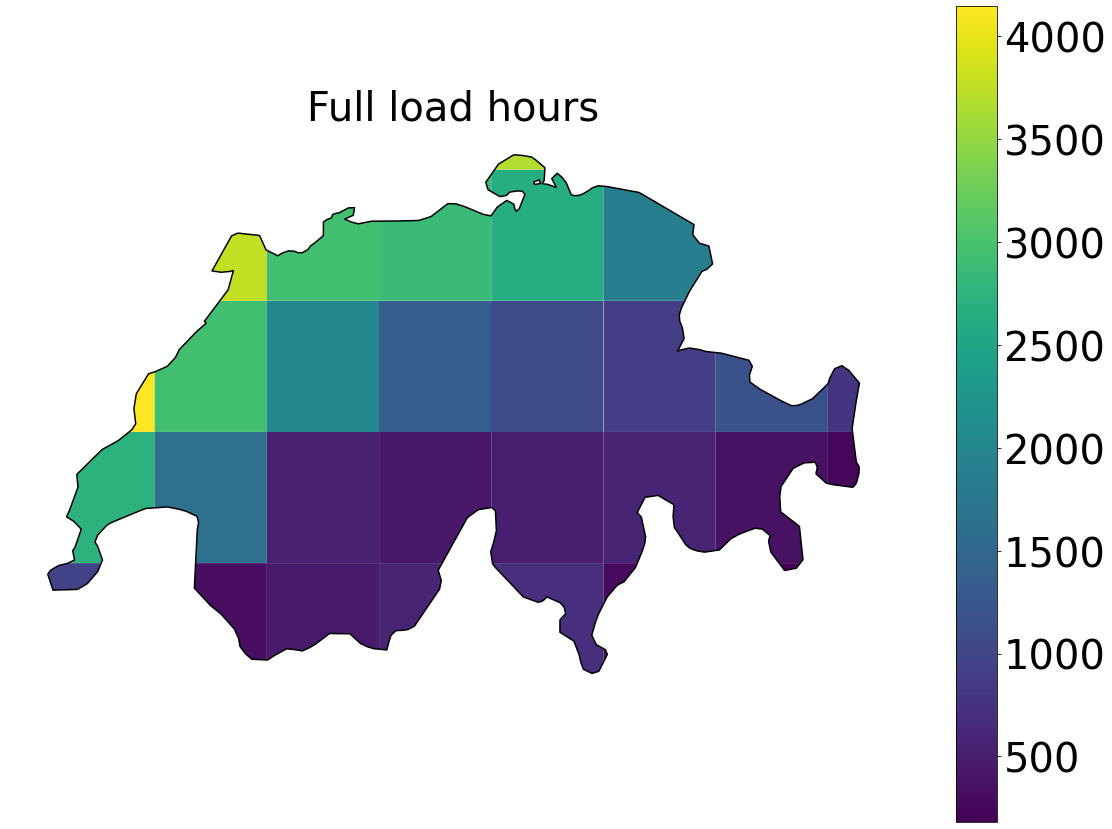

In [14]:
# Full load hours
data = results_gdf
countries = ['Switzerland']
metrics = {'FLh':'Full load hours'}
figsize=(20,15)
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Switzerland_FLh'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

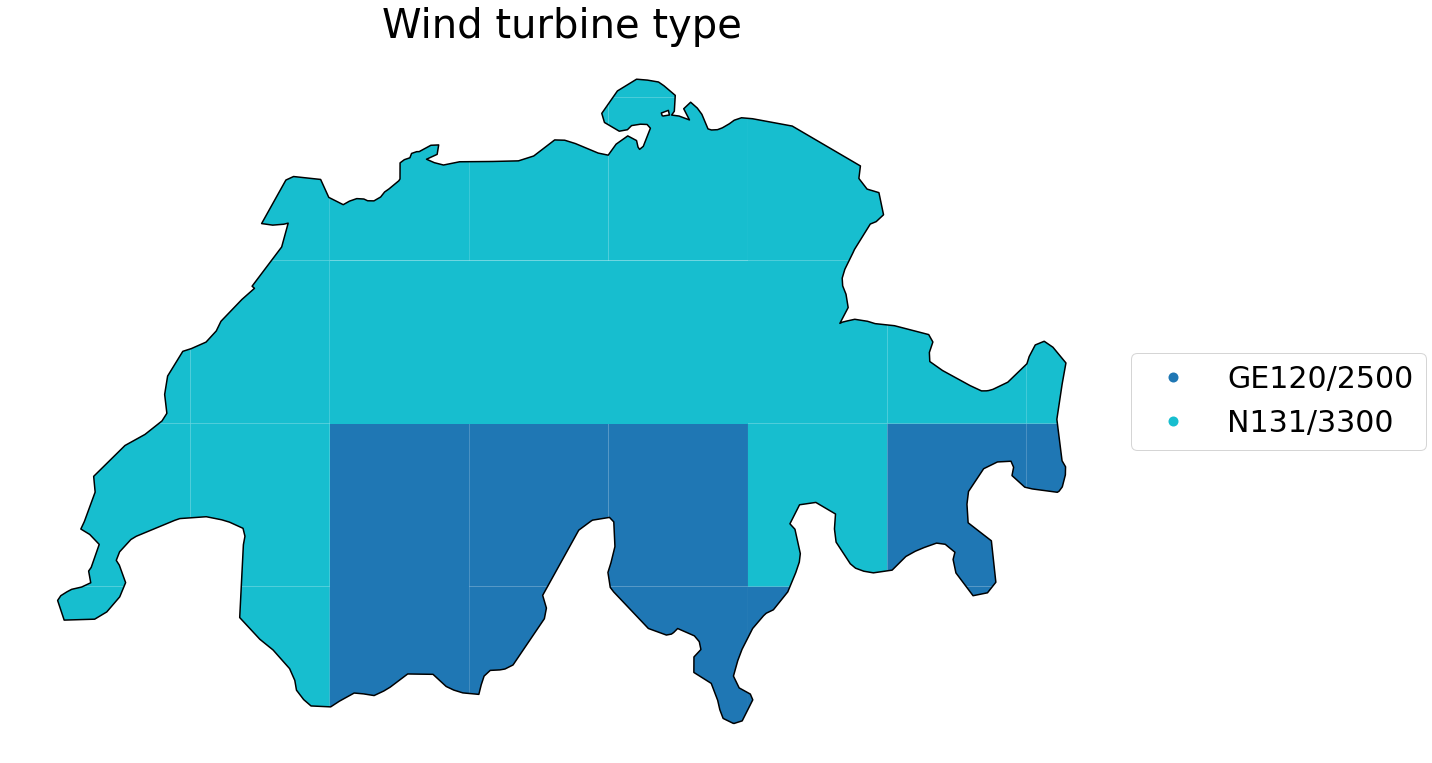

In [18]:
# Full load hours
data = results_gdf.copy()
countries = ['Switzerland']
metrics = {'turbine_type':'Wind turbine type'}
figsize=(20,15)
legend_kwds = {'bbox_to_anchor':(1,0.5),'loc':'center left','ncol':1}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Switzerland_turbine_type'
plt.tight_layout()
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

# Post-processs lcoe

In [15]:
lcoe_results = pd.DataFrame()
for country in europe_grid.country.unique():
    df = pd.read_parquet(f'../../results/01_merra_wind_preprocessing/lcoe_optimal/{country}.parquet.gzip').reset_index(level=2)
    df['v_hub'] = df.v_50m*(df.hub_height/50)**df.hellmann
    df['kWh_max'] = df.kWh
    df = df.groupby(level=[0,1]).agg({'kWh':'sum','kWh_max':'max','v_50m':'mean','v_hub':'mean','rated_power_MW':'min','time':'count','rotor_diameter':'min','turbine_type':'min','specific_capacity_class':'min','rep_hub_height':'min','hub_height':'min'})
    df['FLh'] = df.apply(lambda x: x.kWh/max((x.rated_power_MW*1e3),x.kWh_max),axis=1)
    df.rename(columns={'time':'hours'},inplace=True)
    df['country'] = country
    lcoe_results = lcoe_results.append(df)
lcoe_results

/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/fastparquet/core.py:278: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")
/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/fastparquet/core.py:278: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


kWh      kWh_max     v_50m     v_hub  rated_power_MW  \
lat  lon                                                                      
46.5  12.500  1.323828e+06  5456.622803  2.293885  2.670324             2.3   
      13.125  2.379374e+06  3300.000000  2.280878  3.211061             3.3   
      13.750  5.565850e+06  3300.000000  2.626202  4.577032             3.3   
      14.375  7.609304e+06  6300.000000  2.866405  4.553290             2.3   
      15.000  1.083924e+07  6300.000000  3.085649  5.098543             2.3   
...                    ...          ...       ...       ...             ...   
60.0 -1.250   3.809030e+07  8000.000000  9.415245  9.590472             2.0   
     -0.625   3.782360e+07  8000.000000  9.377261  9.544693             2.0   
60.5 -1.875   3.831276e+07  8000.000000  9.466670  9.644017             2.0   
     -1.250   3.795068e+07  8000.000000  9.383040  9.561840             2.0   
     -0.625   3.760558e+07  8000.000000  9.343440  9.516780             2.0   

              hours  rotor_diameter turbine_type specific_capacity_class  \
lat  lon                                                                   
46.5  12.500   8784           113.0  SWT113/2300                      lo   
      13.125   8784           131.0    N131/3300                      lo   
      13.750   8784           131.0    N131/3300                      lo   
      14.375   8784           113.0  SWT113/2300                      lo   
      15.000   8784           113.0  SWT113/2300                      lo   
...             ...             ...          ...                     ...   
60.0 -1.250    8784            80.0     V80/2000                      hi   
     -0.625    8784            80.0     V80/2000                      hi   
60.5 -1.875    8784            80.0     V80/2000                      hi   
     -1.250    8784            80.0     V80/2000                      hi   
     -0.625    8784            80.0     V80/2000                      hi   

              rep_hub_height  hub_height          FLh         country  
lat  lon                                                               
46.5  12.500            99.5        99.5   242.609475         Austria  
      13.125           164.0       164.0   721.022289         Austria  
      13.750           164.0       164.0  1686.621271         Austria  
      14.375            99.5        99.5  1207.826067         Austria  
      15.000            99.5        99.5  1720.514807         Austria  
...                      ...         ...          ...             ...  
60.0 -1.250             60.0        60.0  4761.288040  United_Kingdom  
     -0.625             60.0        60.0  4727.949524  United_Kingdom  
60.5 -1.875             60.0        60.0  4789.095324  United_Kingdom  
     -1.250             60.0        60.0  4743.834961  United_Kingdom  
     -0.625             60.0        60.0  4700.697074  United_Kingdom  

[3354 rows x 13 columns]

In [16]:
lcoe_results_gdf = gpd.GeoDataFrame(lcoe_results.merge(europe_grid.rename(columns={'name':'country'}),on=['lat','lon','country'],how='left'))
lcoe_results_gdf

,lat,lon,kWh,kWh_max,v_50m,v_hub,rated_power_MW,hours,rotor_diameter,turbine_type,specific_capacity_class,rep_hub_height,hub_height,FLh,country,PV_lat,PV_lon,geometry
0,46.5,12.500,1.323828e+06,5456.622803,2.293885,2.670324,2.3,8784,113.0,SWT113/2300,lo,99.5,99.5,242.609475,Austria,46.706325,12.623342,"POLYGON ((12.36399 46.75000, 12.81250 46.75000..."
1,46.5,13.125,2.379374e+06,3300.000000,2.280878,3.211061,3.3,8784,131.0,N131/3300,lo,164.0,164.0,721.022289,Austria,46.667058,13.150482,"POLYGON ((12.81250 46.75000, 13.43750 46.75000..."
2,46.5,13.750,5.565850e+06,3300.000000,2.626202,4.577032,3.3,8784,131.0,N131/3300,lo,164.0,164.0,1686.621271,Austria,46.639056,13.766162,"POLYGON ((13.43750 46.75000, 14.06250 46.75000..."
3,46.5,14.375,7.609304e+06,6300.000000,2.866405,4.553290,2.3,8784,113.0,SWT113/2300,lo,99.5,99.5,1207.826067,Austria,46.592609,14.381355,"POLYGON ((14.06250 46.75000, 14.68750 46.75000..."
4,46.5,15.000,1.083924e+07,6300.000000,3.085649,5.098543,2.3,8784,113.0,SWT113/2300,lo,99.5,99.5,1720.514807,Austria,46.663584,14.928533,"POLYGON ((14.68750 46.75000, 15.31250 46.75000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,60.0,-1.250,3.809030e+07,8000.000000,9.415245,9.590472,2.0,8784,80.0,V80/2000,hi,60.0,60.0,4761.288040,United_Kingdom,60.056735,-1.258253,"MULTIPOLYGON (((-1.37861 60.25000, -1.19517 60..."
3350,60.0,-0.625,3.782360e+07,8000.000000,9.377261,9.544693,2.0,8784,80.0,V80/2000,hi,60.0,60.0,4727.949524,United_Kingdom,NaN,NaN,None
3351,60.5,-1.875,3.831276e+07,8000.000000,9.466670,9.644017,2.0,8784,80.0,V80/2000,hi,60.0,60.0,4789.095324,United_Kingdom,60.277697,-1.621464,"MULTIPOLYGON (((-1.56250 60.30923, -1.56250 60..."
3352,60.5,-1.250,3.795068e+07,8000.000000,9.383040,9.561840,2.0,8784,80.0,V80/2000,hi,60.0,60.0,4743.834961,United_Kingdom,60.407124,-1.311821,"MULTIPOLYGON (((-1.10472 60.48555, -1.12750 60..."


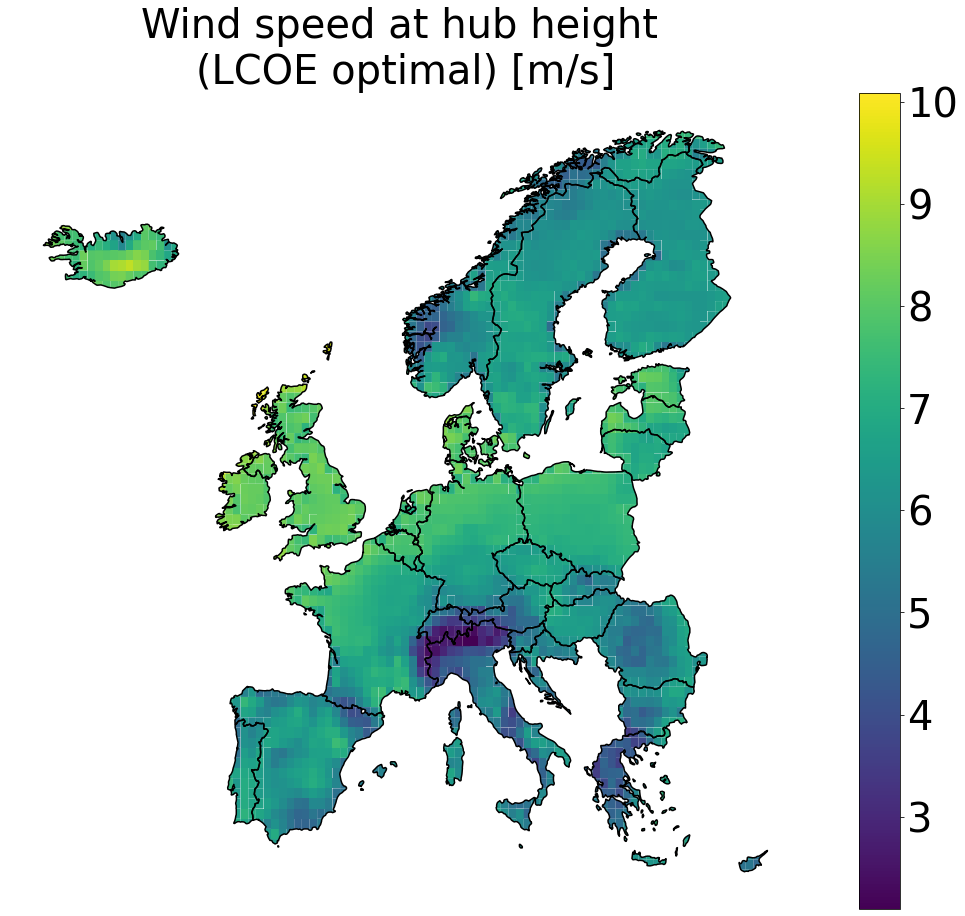

In [17]:
# Wind speed at hub height
data = lcoe_results_gdf
countries = europe_grid.country.unique()
metrics = {'v_hub':'Wind speed at hub height \n(LCOE optimal) [m/s]'}
figsize=(20,15)
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Europe_lcoe_v_hub'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

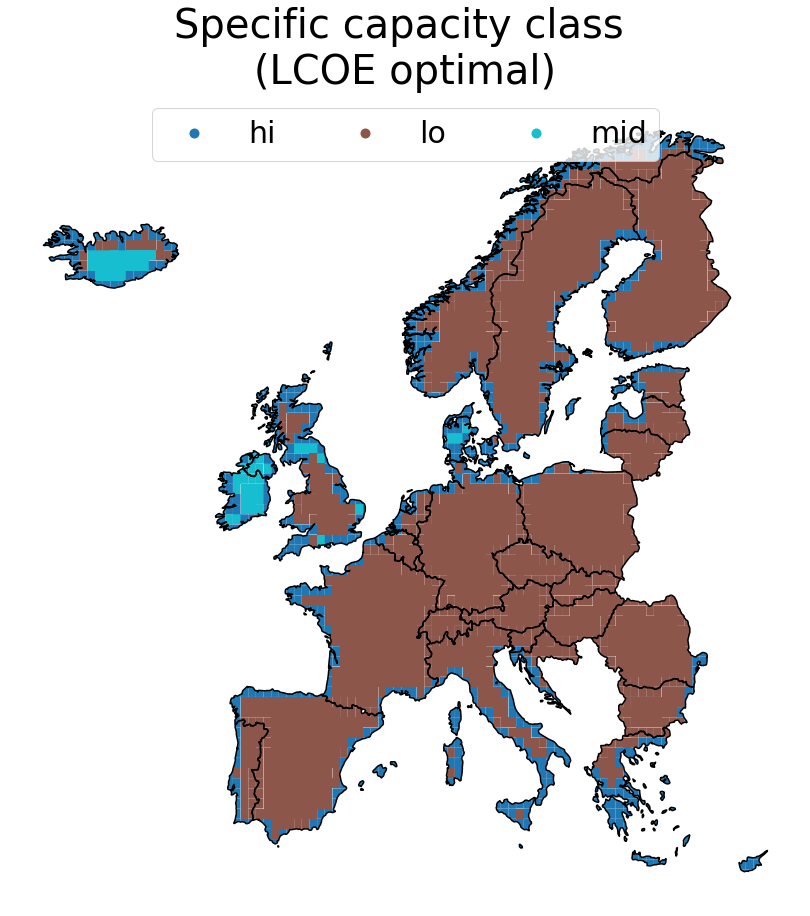

In [18]:
# Wind specific capacity class
data = lcoe_results_gdf
countries = europe_grid.country.unique()
metrics = {'specific_capacity_class':'Specific capacity class \n(LCOE optimal)'}
figsize=(20,15)
plot_results(data,countries,metrics,figsize=figsize)
save_file_name = 'Europe_lcoe_specific_capacity_class'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

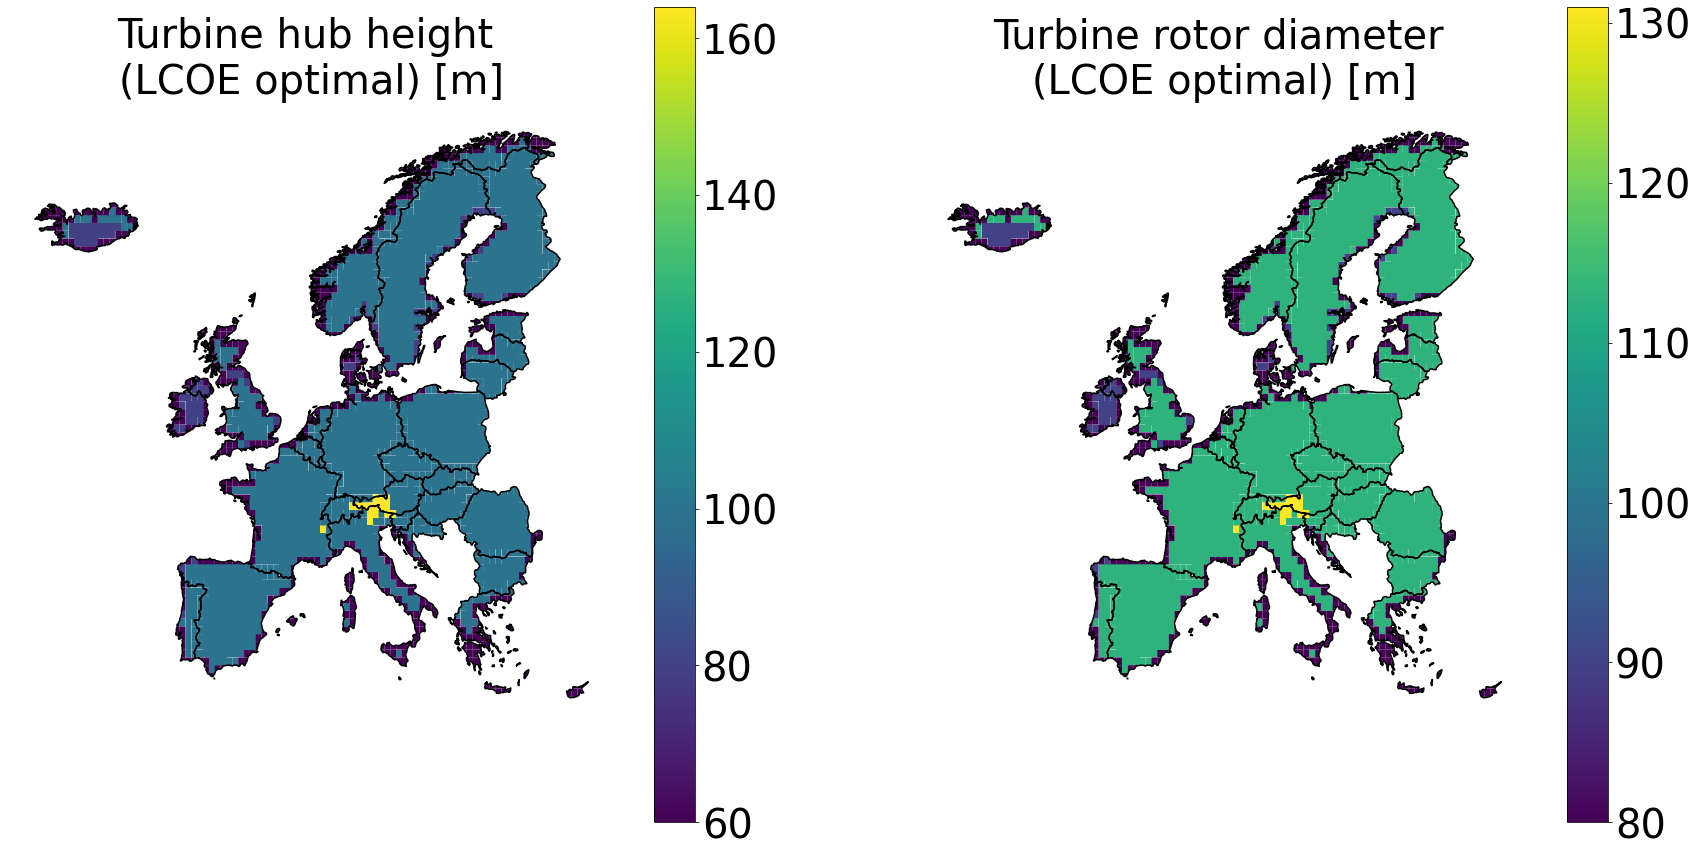

In [19]:
# Turbine hub height & rotor diameter
data = lcoe_results_gdf
countries = europe_grid.country.unique()
metrics = {'hub_height':'Turbine hub height \n(LCOE optimal) [m]','rotor_diameter':'Turbine rotor diameter \n(LCOE optimal) [m]'}
figsize=(30,15)
fontsize=40
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds,fontsize=fontsize)
save_file_name = 'Europe_lcoe_hub_and_rotor'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

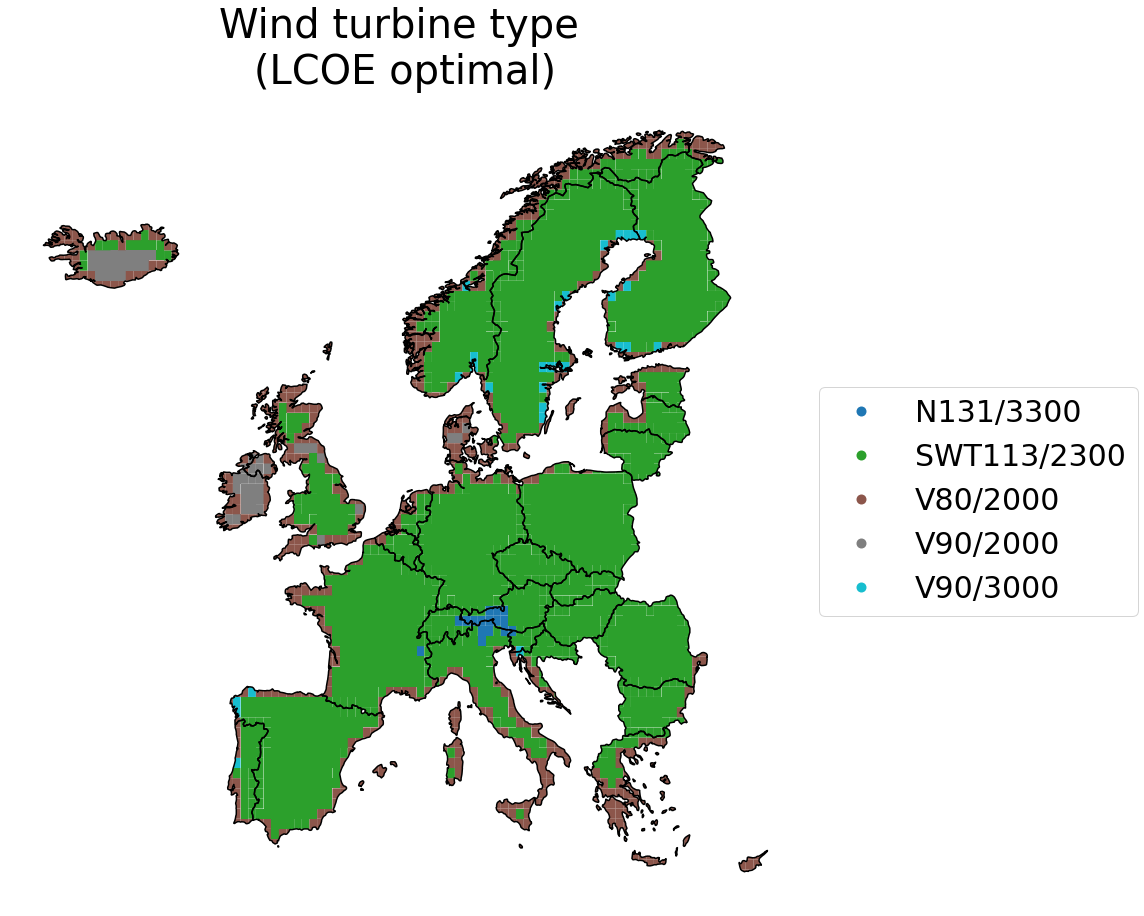

In [20]:
# Wind turbine type
data = lcoe_results_gdf
countries = europe_grid.country.unique()
metrics = {'turbine_type':'Wind turbine type \n(LCOE optimal)'}
figsize=(20,15)
legend_kwds = {'bbox_to_anchor':(1,0.5),'loc':'center left','ncol':1}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Europe_lcoe_turbine_type'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)

In [21]:
pd.DataFrame(lcoe_results_gdf.turbine_type.value_counts()).sort_index()

,turbine_type
N131/3300,31
SWT113/2300,2037
V80/2000,1197
V90/2000,57
V90/3000,32


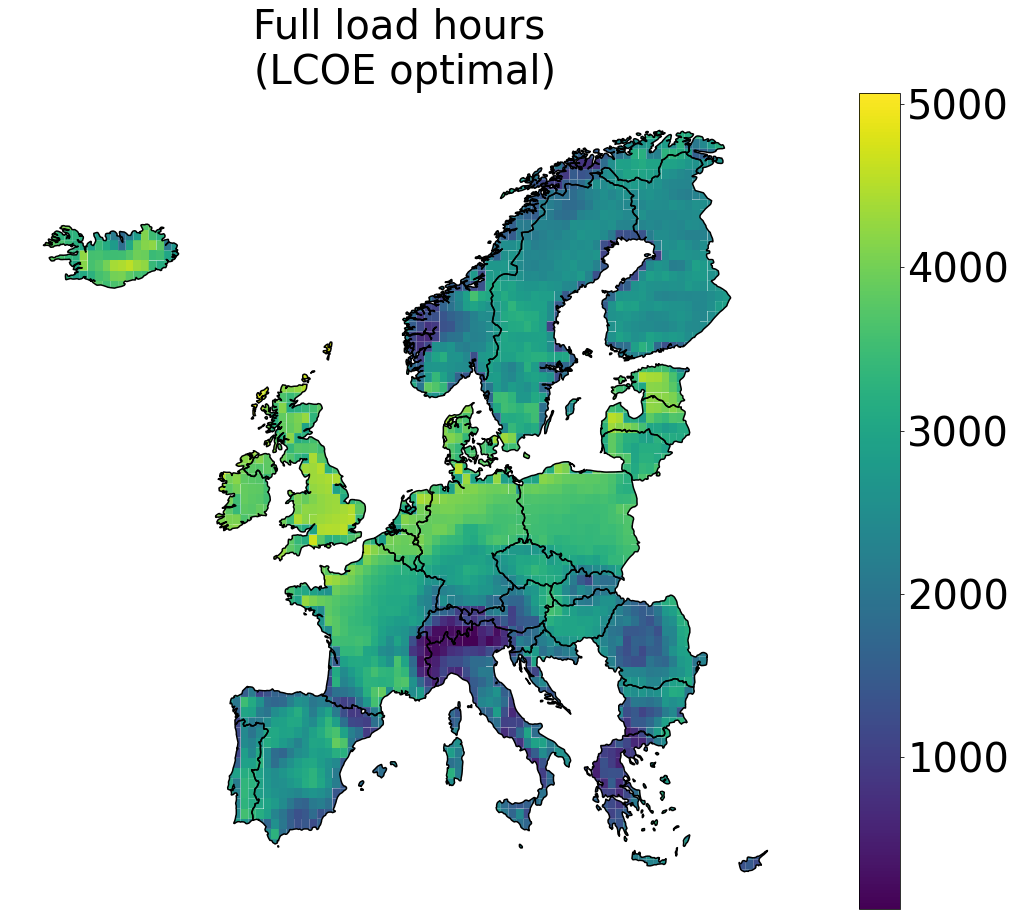

In [22]:
# Full load hours
data = lcoe_results_gdf
countries = europe_grid.country.unique()
metrics = {'FLh':'Full load hours \n(LCOE optimal)'}
figsize=(20,15)
legend_kwds={'orientation':'vertical'}
plot_results(data,countries,metrics,figsize=figsize,legend_kwds=legend_kwds)
save_file_name = 'Europe_lcoe_FLh'
# plt.savefig(f'../../gfx/01_merra_wind_preprocessing/{save_file_name}.png',dpi=400)